# Fast Fourier Transforms (FFT)

Let $x_0, \ldots, x_{n-1}$ be complex numbers. The [Discrete Fourier Transform (DFT)](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform) is defined by the formula:

$$
  X_k = \sum_{m=0}^{n-1} x_m e^{-i2\pi k m/n} \qquad k = 0,\ldots,n-1,
$$

Let's define a stream, consisting of exactly 20 sine waves in 1024 samples:

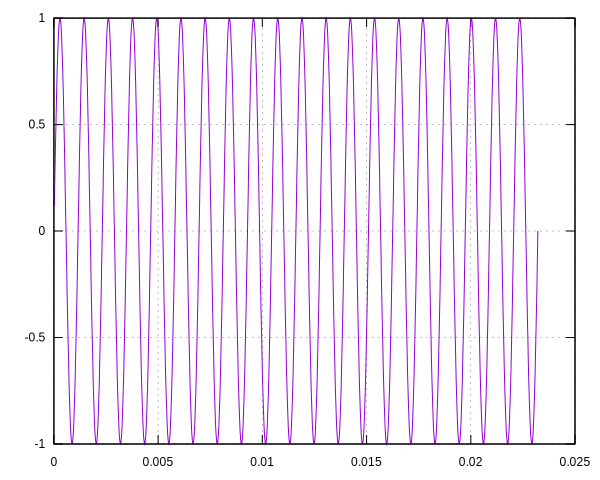

In [1]:
sines = Stream.SinOsc(samplerate*20/1024):sub(1, 1024)
sines:gnuplot()

The bins of the corresponding frequency spectrum correspond to frequencies according to the following formula:

$$
  f_i = {i {f_{srate} \over N}}
$$

Plotting the frequency spectrum's magnitudes of `sines` should therefore give us a clear signal around bin 20 (Lua index 21).

**NOTE:** This does not need windowing since the waves fit perfectly into 1024 sample buffer.

{0, 0, 0, 1.173742634399e-14, 0, 0, 0, 3.9584680075211e-15, 0, 0, 0, 512, 0, 0, 0, 2.2315199565268e-14, 0, 0, 0, 8.6716166150709e-15, 0}


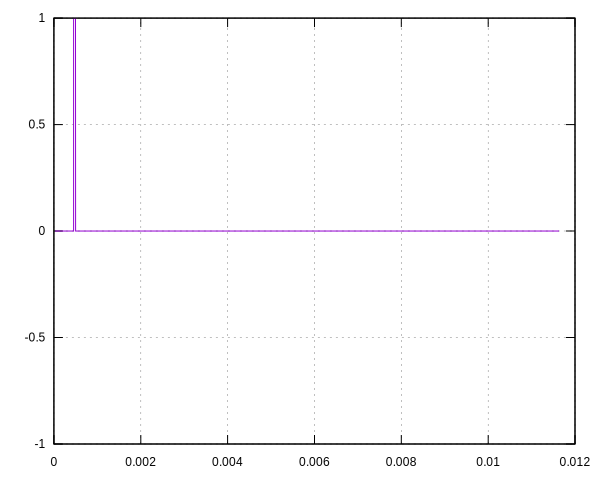

In [11]:
spectrum = tostream(magnitude(FFT(sines)))
print(spectrum:sub(10, 30))
spectrum:gnuplot()

Testing the inverse FFT - looks just like the original wave:

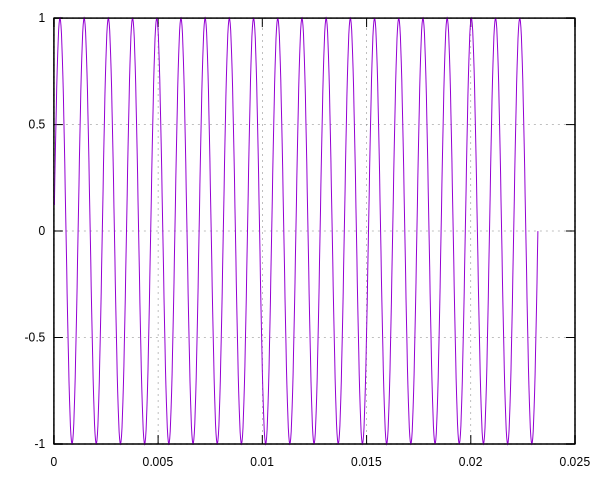

In [13]:
IFFT(FFT(sines)):gnuplot()

With 20.5 sines in the fragment, the plot is much better when applying a windowing function:

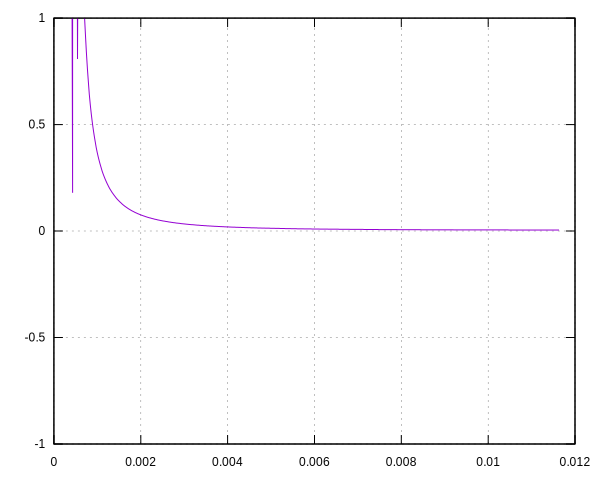

In [14]:
tostream(magnitude(FFT(Hamming(Stream.SinOsc(samplerate*20.5/1024):sub(1, 1024))))):gnuplot()

Testing phase plotting. This is 20 sines but with phase 0.7 ($0.7 \times 2\pi$).

**FIXME:** How exactly to interpret these numbers?

{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9390625, 0, 0, 0, 0, 0, 0, 0, 0, 0}


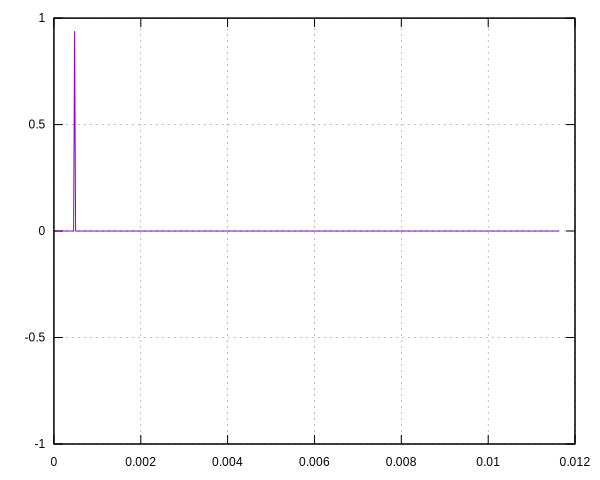

In [18]:
spectrum = tostream(phase(FFT(Stream.SinOsc(samplerate*20/1024, 0.7):sub(1, 1024))))
print(spectrum:sub(10, 30))
spectrum:gnuplot()

Let's try some naive real-time pitch shifting.
This however is [not easy to get right](https://www.reddit.com/r/DSP/comments/k6t24c/pitch_shifting_algorithm_in_frequency_domain/)!

In [20]:
-- FIXME: Use a different sound file!
robin = SndfileStream("tracks/robin-mono.wav"):sub(sec(10.284), sec(17.466)):eval()
robin:play()
robin:FFT(1024):map(function(spectrum)
    assert(#spectrum == 513)
    -- NOTE: We cannot use Stream:resample() as it won't work with complex samples.
    for i = 1, 512/2 do spectrum[i] = spectrum[i*2] end
    for i = 512/2+1, 512 do spectrum[i] = 0i end
    return spectrum
end):IFFT(1024):play()

Let's generate and plot the spectrum of a sine mixed with some noise:

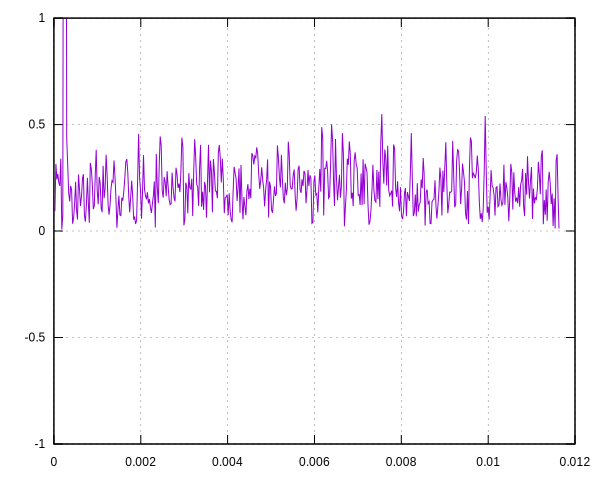

In [21]:
noisy = Stream.SinOsc(440):mix(NoiseStream, 0.4)
tostream(magnitude(FFT(Hamming(noisy:sub(1, 1024))))):mul(0.05):gnuplot()

Try some very naive noise cancelling.

**WARNING:** This plays indefinitely. Interrupt via Kernel &rarr; "Interrupt Kernel".

In [22]:
noisy:FFT(1024, Hamming):map(function(spectrum)
    assert(#spectrum == 513)
    for i = 1, #spectrum do
        if (spectrum[i].re^2 + spectrum[i].im^2)^.5*0.05 < 0.8 then spectrum[i] = 0i end
    end
    return spectrum
end):IFFT(1024):play()

n/a: fft.lua:124: interrupted!